GOOG & MSFT

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
class TradingStrategyAnalyzer:
    def __init__(self):
        pass

    def performance(self, x, ntrades=1, cost=0):
        """
        Calculates the performance of a stock or portfolio given the returns data.
        
        Parameters:
        x (pd.Series): an array containing the daily returns of the stock or portfolio.
        ntrades (int, optional): the number of trades. Default is 1.
        cost (float, optional): the transaction cost for each trade. Default is 0.
        
        Returns:
        Series: A pandas Series object containing the performance statistics of the stock or portfolio. 
        The Series object has the following indices:
            - Cumulative Return
            - Annual Return
            - Annualized Sharpe Ratio
            - Win %
            - Annualized Volatility
            - Maximum Drawdown
            - Max Length Drawdown
            - n.trades
        """ 
        cumRetx = np.cumsum(x, axis=0) - ntrades * cost
        annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
        sharpex = annRetx / np.std(x, ddof=1) * np.sqrt(252)
        winpctx = np.count_nonzero(x > 0) / np.count_nonzero(x)
        annSDx = np.std(x, ddof=1) * np.sqrt(252)

        DDs = np.minimum.accumulate(cumRetx) - cumRetx
        maxDDx = DDs.min()
        maxLx = (cumRetx == DDs).argmax()

        Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
        names = np.array(["Cumulative Return", "Annual Return", "Annualized Sharpe Ratio",
        "Win %", "Annualized Volatility", "Maximum Drawdown", "Max Length Drawdown", "n.trades"])
        return pd.Series(Perf, index=names, name=x.name)

    def test_MA_strategy(self, myStock, ts=None, s=5, m=20, longshort=0, tcost=0):
        """
        Calculates the performance of a moving average crossover strategy.

        Parameters:
        myStock (ndarray): an array containing the daily returns of the stock.
        ts (ndarray, optional): an array containing the daily returns of the stock. Default is None.
        s (int, optional): the short window. Default is 5.
        m (int, optional): the long window. Default is 20.
        longshort (int, optional): the long/short strategy. Default is 0. for short use -1
        tcost (float, optional): the transaction cost for each trade. Default is 0.

        Returns:
        DataFrame: A pandas DataFrame object containing the performance statistics of the strategy and the benchmark.
        The DataFrame object has the following columns:
            - MAx: the performance statistics of the strategy.
            - BH: the performance statistics of the benchmark.
        """
        if ts is None:
            ts = myStock

        sig = pd.Series(np.where(
            pd.Series(ts).rolling(s).mean() > pd.Series(ts).rolling(m).mean(), 1, longshort
            )).shift(1)
        sig.index = ts.index

        bmkReturns = (myStock / myStock.shift(1) - 1).dropna()
        myReturns = bmkReturns * sig
        myReturns.name = "MAx"
        bmkReturns.name = "BH"

        tt = pd.concat([myReturns, bmkReturns], axis=1).dropna()

        lruns = np.count_nonzero(np.diff(sig)) + 1
        bhPerf = self.performance(tt.BH, 2, tcost)
        maxPerf = self.performance(tt.MAx, lruns, tcost)

        plt.figure(figsize=(12, 6))
        plt.plot(np.cumsum(tt.MAx, axis=0), label="MAx")
        plt.plot(np.cumsum(tt.BH, axis=0), label="BH")
        plt.legend()
        plt.show()

        return pd.concat([maxPerf, bhPerf], axis=1)

    def rolling_test_MA_strategy(self, my_stock, ts=None, s=5, m=20, longshort=0, w_size=252):
        """
        Calculates the performance of a moving average crossover strategy.

        Parameters:
        my_stock (ndarray): an array containing the daily returns of the stock.
        ts (ndarray, optional): an array containing the daily returns of the stock. Default is None.
        s (int, optional): the short window. Default is 5.
        m (int, optional): the long window. Default is 20.
        longshort (int, optional): the long/short strategy. Default is 0.
        w_size (int, optional): the window size. Default is 252.

        Returns:
        DataFrame: A pandas DataFrame object containing the performance statistics of the strategy and the benchmark.
        The DataFrame object has the following columns:
            - MAx: the performance statistics of the strategy.
            - BH: the performance statistics of the benchmark.
        """
        if ts is None:
            ts = my_stock

        sig = (pd.Series(np.where(ts.rolling(window=s).mean() > ts.rolling(window=m).mean(), 1, longshort), name='sig')
                .shift(1))
        sig.index = ts.index

        bmk_returns = (my_stock / my_stock.shift(1) - 1).rename("BH")
        my_returns = bmk_returns * sig
        my_returns.rename("Me", inplace=True)
        tt = pd.concat([bmk_returns, my_returns], axis=1).dropna()
        n_windows = int(tt.shape[0] - w_size)
        if n_windows < 1:
            raise ValueError("Window size too large")
        
        perform = []
        for i in range(n_windows):
            bh_stra = tt.iloc[i:w_size+i, 0]
            my_stra = tt.iloc[i:w_size+i, 1]
            perform.append([bh_stra.mean(), my_stra.mean()])
        perform = np.array(perform)
        
        bh_means = perform[:,0].mean()
        me_means = perform[:,1].mean()
        mean_perf = np.array([bh_means, me_means])
        mean_perf = pd.DataFrame(mean_perf, index=["BH", "Me"], columns=["AvgPerf"])
        
        return {"AvgPerf": mean_perf, "NumWindows": n_windows}

In [13]:
tau=1 # because the data is daily
goog = pd.read_csv('GOOG.csv', sep = ',')
goog = goog.iloc[:, 1:] # removing the first column (unnamed)
msft = pd.read_csv('MSFT.csv', sep = ',')
msft = msft.iloc[:, 1:]

print(goog.head())
print(msft.head())

         Date         Open         High          Low        Close  \
0  2018-01-02  1048.339966  1066.939941  1045.229980  1065.000000   
1  2018-01-03  1064.310059  1086.290039  1063.209961  1082.479980   
2  2018-01-04  1088.000000  1093.569946  1084.001953  1086.400024   
3  2018-01-05  1094.000000  1104.250000  1092.000000  1102.229980   
4  2018-01-08  1102.229980  1111.270020  1101.619995  1106.939941   

     Adj Close   Volume     RVT  positivePartscr  negativePartscr  \
0  1065.000000  1237600  0.0009           0.0169           0.0169   
1  1082.479980  1430200  0.0006           0.0165           0.0180   
2  1086.400024  1004600  0.0014           0.0071           0.0231   
3  1102.229980  1279100  0.0015           0.0062           0.0403   
4  1106.939941  1047600  0.0016           0.0109           0.0160   

   fearPartscr  findownPartscr  finupPartscr  finhypePartscr  \
0       0.0018          0.0073        0.0369          0.0093   
1       0.0007          0.0079        0.02

In [14]:
df_goog = pd.DataFrame(goog.values[:, 1:], index=pd.to_datetime(goog.values[:, 0]), columns=goog.columns[1:])
df_msft = pd.DataFrame(msft.values[:, 1:], index=pd.to_datetime(msft.values[:, 0]), columns=msft.columns[1:])

In [17]:
# transform all columns to float
df_goog = df_goog.astype(float)
df_msft = df_msft.astype(float)

In [18]:
## Target :  Adj Close Price 
target_goog = df_goog['Adj Close']
target_msft = df_msft['Adj Close']

target_goog.name = "GOOG"
target_msft.name = "GOOG"

print(target_goog.head())
print(target_msft.head())

2018-01-02    1065.000000
2018-01-03    1082.479980
2018-01-04    1086.400024
2018-01-05    1102.229980
2018-01-08    1106.939941
Name: GOOG, dtype: float64
2018-01-02    82.798996
2018-01-03    83.184326
2018-01-04    83.916473
2018-01-05    84.956886
2018-01-08    85.043571
Name: GOOG, dtype: float64


Indicators

In [19]:
# Para GOOG
negativeP_goog = df_goog['negativePartscr'].dropna()
negativeP_goog.name = "negative"
uncertaintyP_goog = df_goog['uncertaintyPartscr'].dropna()
findownP_goog = df_goog['findownPartscr'].dropna()

positiveP_goog = df_goog['positivePartscr'].dropna()
positiveP_goog.name = "positive"
certaintyP_goog = df_goog['certaintyPartscr'].dropna()
finupP_goog = df_goog['finupPartscr'].dropna()

BULL_goog = 0.33 * (positiveP_goog + certaintyP_goog + finupP_goog)
BEAR_goog = 0.33 * (negativeP_goog + uncertaintyP_goog + findownP_goog)
BULL_goog.name = "BULL"
BEAR_goog.name = "BEAR"

display(BULL_goog.head())
display(BEAR_goog.head())

# Para MSFT
negativeP_msft = df_msft['negativePartscr'].dropna()
negativeP_msft.name = "negative"
uncertaintyP_msft = df_msft['uncertaintyPartscr'].dropna()
findownP_msft = df_msft['findownPartscr'].dropna()

positiveP_msft = df_msft['positivePartscr'].dropna()
positiveP_msft.name = "positive"
certaintyP_msft = df_msft['certaintyPartscr'].dropna()
finupP_msft = df_msft['finupPartscr'].dropna()

BULL_msft = 0.33 * (positiveP_msft + certaintyP_msft + finupP_msft)
BEAR_msft = 0.33 * (negativeP_msft + uncertaintyP_msft + findownP_msft)
BULL_msft.name = "BULL"
BEAR_msft.name = "BEAR"

display(BULL_msft.head())
display(BEAR_msft.head())

2018-01-02    0.022275
2018-01-03    0.018744
2018-01-04    0.009966
2018-01-05    0.007524
2018-01-08    0.008217
Name: BULL, dtype: float64

2018-01-02    0.009702
2018-01-03    0.010428
2018-01-04    0.012771
2018-01-05    0.019305
2018-01-08    0.007986
Name: BEAR, dtype: float64

2018-01-02    0.022638
2018-01-03    0.018777
2018-01-04    0.009240
2018-01-05    0.012210
2018-01-08    0.017028
Name: BULL, dtype: float64

2018-01-02    0.010725
2018-01-03    0.011253
2018-01-04    0.016764
2018-01-05    0.020592
2018-01-08    0.007095
Name: BEAR, dtype: float64

**PNlog**: Measures the balance between negative and positive sentiment. 

In [36]:
# Para GOOG
PNlog_goog = 0.5 * np.log((positiveP_goog + 1) / (negativeP_goog + 1))
PNlog_goog.name = "PNlog_GOOG"
display(PNlog_goog.head())

# Para MSFT
PNlog_msft = 0.5 * np.log((positiveP_msft + 1) / (negativeP_msft + 1))
PNlog_msft.name = "PNlog_MSFT"
display(PNlog_msft.head())

2018-01-02    0.000000
2018-01-03   -0.000737
2018-01-04   -0.007881
2018-01-05   -0.016664
2018-01-08   -0.002516
Name: PNlog_GOOG, dtype: float64

2018-01-02    0.002154
2018-01-03    0.000985
2018-01-04   -0.011016
2018-01-05   -0.013400
2018-01-08    0.011034
Name: PNlog_MSFT, dtype: float64

In [20]:
# Para GOOG
BULL_BEAR_goog = BULL_goog + BEAR_goog
BULL_BEAR_goog[BULL_BEAR_goog == 0] = np.nan  # Evitar división por cero
BBr_goog = 100 * BULL_goog / BULL_BEAR_goog
BBr_goog.fillna(method='ffill', inplace=True)
BBr_goog.fillna(method='bfill', inplace=True)
BBr_goog.name = "BBr_GOOG"

display(BBr_goog.head())

# Para MSFT
BULL_BEAR_msft = BULL_msft + BEAR_msft
BULL_BEAR_msft[BULL_BEAR_msft == 0] = np.nan  # Evitar división por cero
BBr_msft = 100 * BULL_msft / BULL_BEAR_msft
BBr_msft.fillna(method='ffill', inplace=True)
BBr_msft.fillna(method='bfill', inplace=True)
BBr_msft.name = "BBr_MSFT"

display(BBr_msft.head())

/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/4247397546.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr_goog.fillna(method='ffill', inplace=True)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/4247397546.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr_goog.fillna(method='bfill', inplace=True)


2018-01-02    69.659443
2018-01-03    64.253394
2018-01-04    43.831640
2018-01-05    28.044280
2018-01-08    50.712831
Name: BBr_GOOG, dtype: float64

/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/4247397546.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr_msft.fillna(method='ffill', inplace=True)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/4247397546.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr_msft.fillna(method='bfill', inplace=True)


2018-01-02    67.853610
2018-01-03    62.527473
2018-01-04    35.532995
2018-01-05    37.223340
2018-01-08    70.588235
Name: BBr_MSFT, dtype: float64

/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

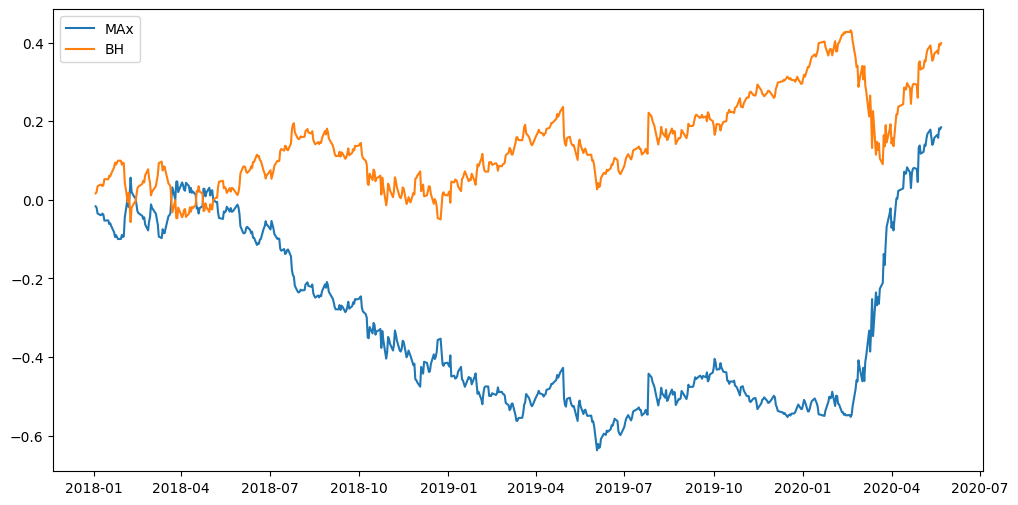

Resultados para GOOG:


,MAx,BH
Cumulative Return,-0.765409,0.298745
Annual Return,-0.455534,0.115837
Annualized Sharpe Ratio,-365.129032,92.888930
Win %,0.497504,0.535774
Annualized Volatility,0.314395,0.314256
Maximum Drawdown,-0.821610,-0.487803
Max Length Drawdown,0.000000,0.000000
n.trades,19.000000,2.000000


In [21]:
# Para GOOG
target = target_goog  # Serie de precios objetivo
BEAR_var = BEAR_goog  # Puedes cambiar por BULL_goog, BBr_goog, PNlog_goog, etc.

# Ejecutar la estrategia usando la clase
analyzer = TradingStrategyAnalyzer()
res_goog = analyzer.test_MA_strategy(target, BEAR_var, s=30, m=100, longshort=-1, tcost=0.05)
print("Resultados para GOOG:")
display(res_goog)

/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

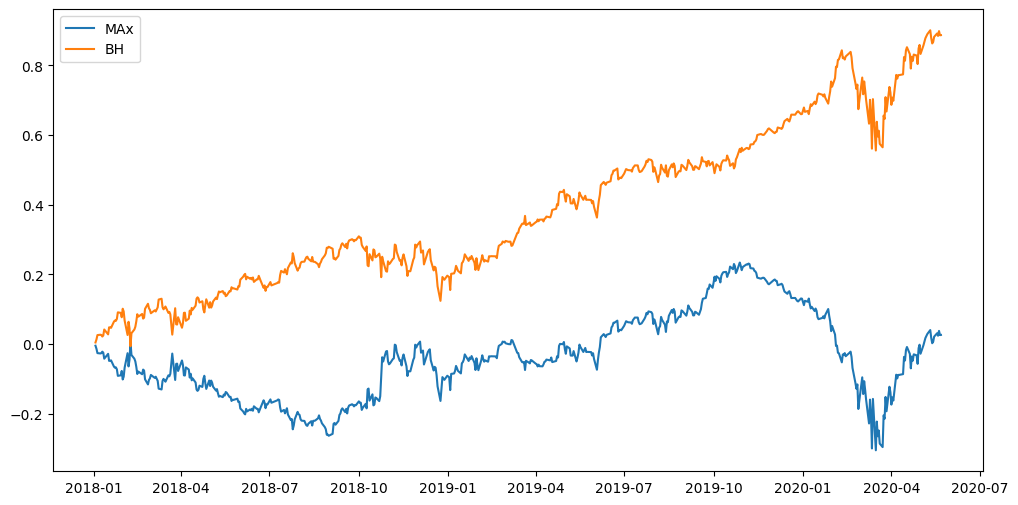

Resultados para MSFT:


,MAx,BH
Cumulative Return,-1.323659,0.786596
Annual Return,NaN,0.279678
Annualized Sharpe Ratio,NaN,213.593720
Win %,0.489831,0.567797
Annualized Volatility,0.330820,0.329966
Maximum Drawdown,-0.497048,-0.906716
Max Length Drawdown,0.000000,0.000000
n.trades,27.000000,2.000000


In [22]:
# Para MSFT
target = target_msft
BEAR_var = BEAR_msft  # O el indicador que quieras probar

res_msft = analyzer.test_MA_strategy(target, BEAR_var, s=30, m=100, longshort=-1, tcost=0.05)
print("Resultados para MSFT:")
display(res_msft)

/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

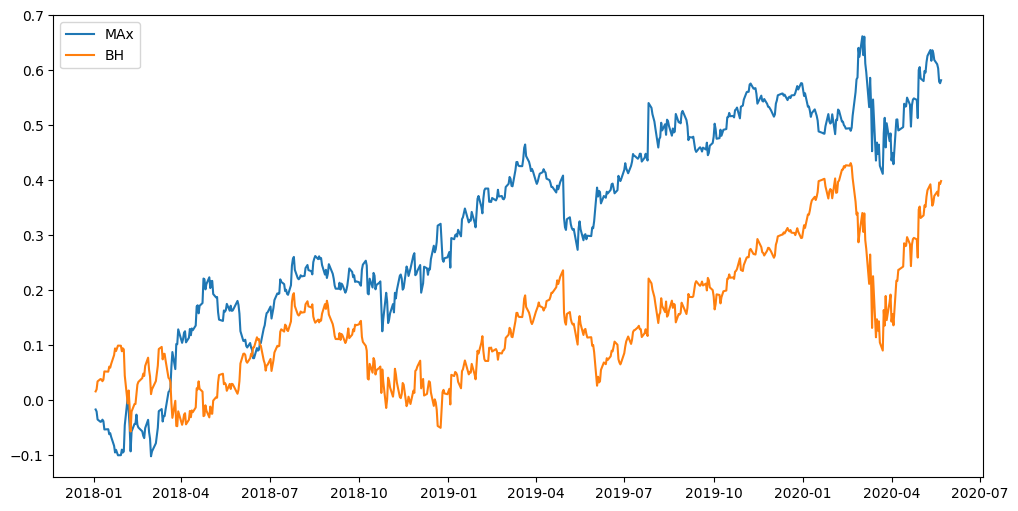

Resultados para GOOG:


,MAx,BH
Cumulative Return,-0.307980,0.378745
Annual Return,-0.143038,0.144157
Annualized Sharpe Ratio,-114.774294,115.599053
Win %,0.527454,0.535774
Annualized Volatility,0.314056,0.314256
Maximum Drawdown,-0.763415,-0.487803
Max Length Drawdown,0.000000,0.000000
n.trades,89.000000,2.000000


In [26]:
analyzer = TradingStrategyAnalyzer()

# Elige el target y el explanatory variable (puedes cambiar BEAR_goog por BULL_goog, BBr_goog, etc.)
target = target_goog
ev = BEAR_goog

res_goog = analyzer.test_MA_strategy(target, ev, s=10, m=25, longshort=-1, tcost=0.01)
print("Resultados para GOOG:")
display(res_goog)

/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

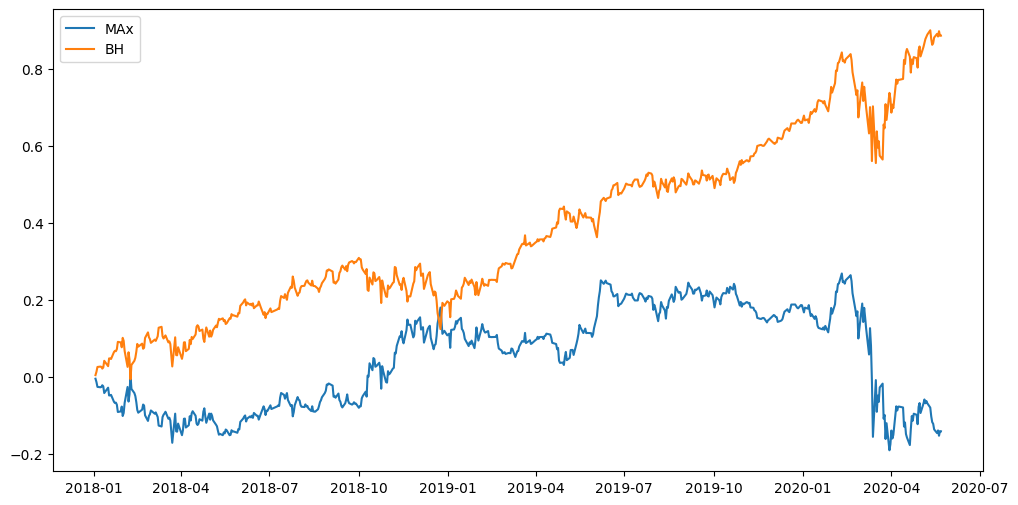

Resultados para MSFT:


,MAx,BH
Cumulative Return,-0.881252,0.866596
Annual Return,-0.595652,0.303722
Annualized Sharpe Ratio,-453.763211,231.956673
Win %,0.498305,0.567797
Annualized Volatility,0.330799,0.329966
Maximum Drawdown,-0.439916,-0.906716
Max Length Drawdown,0.000000,0.000000
n.trades,74.000000,2.000000


In [27]:
analyzer = TradingStrategyAnalyzer()

target = target_msft
ev = BEAR_msft

res_msft = analyzer.test_MA_strategy(target, ev, s=10, m=25, longshort=-1, tcost=0.01)
print("Resultados para MSFT:")
display(res_msft)

/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

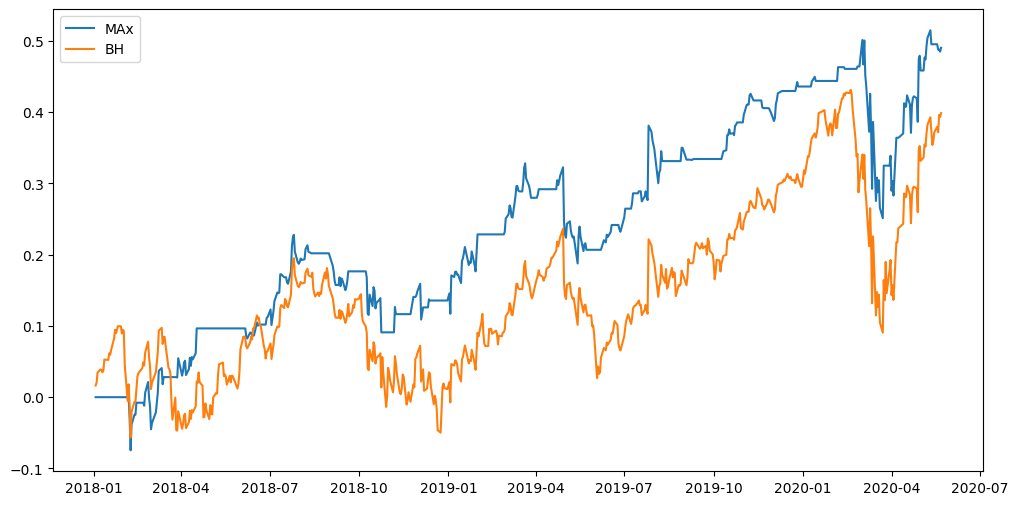

Resultados para GOOG:


,MAx,BH
Cumulative Return,-0.399617,0.378745
Annual Return,-0.192589,0.144157
Annualized Sharpe Ratio,-192.681993,115.599053
Win %,0.565068,0.535774
Annualized Volatility,0.251878,0.314256
Maximum Drawdown,-0.589415,-0.487803
Max Length Drawdown,0.000000,0.000000
n.trades,89.000000,2.000000


In [31]:
analyzer = TradingStrategyAnalyzer()

# Elige el target y el explanatory variable (puedes cambiar BEAR_goog por otro indicador)
target = target_goog
ev = BEAR_goog

res_goog = analyzer.test_MA_strategy(target, ev, s=10, m=25, longshort=0, tcost=0.01)
print("Resultados para GOOG:")
display(res_goog)

/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

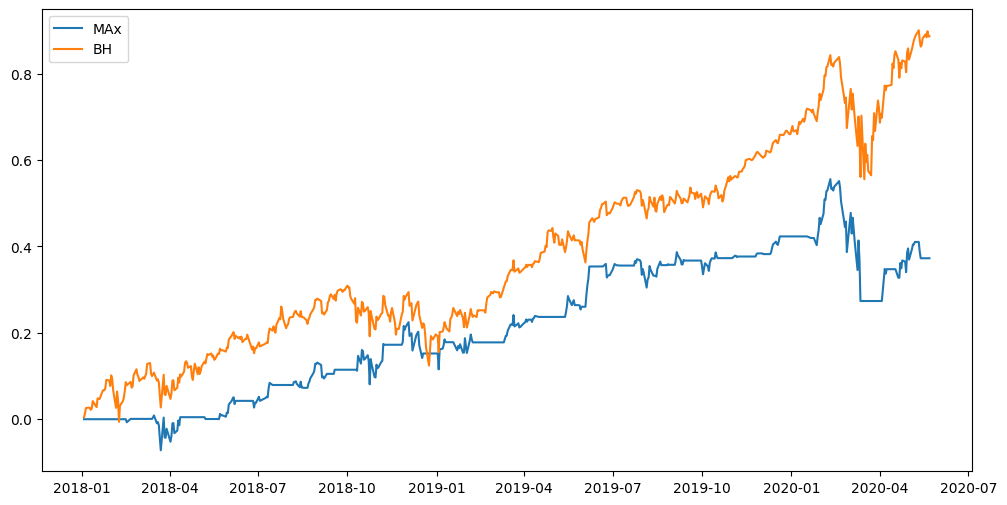

Resultados para MSFT:


,MAx,BH
Cumulative Return,-0.367328,0.866596
Annual Return,-0.176793,0.303722
Annualized Sharpe Ratio,-198.742949,231.956673
Win %,0.569892,0.567797
Annualized Volatility,0.224168,0.329966
Maximum Drawdown,-0.627877,-0.906716
Max Length Drawdown,0.000000,0.000000
n.trades,74.000000,2.000000


In [30]:
analyzer = TradingStrategyAnalyzer()

target = target_msft
ev = BEAR_msft

res_msft = analyzer.test_MA_strategy(target, ev, s=10, m=25, longshort=0, tcost=0.01)
print("Resultados para MSFT:")
display(res_msft)

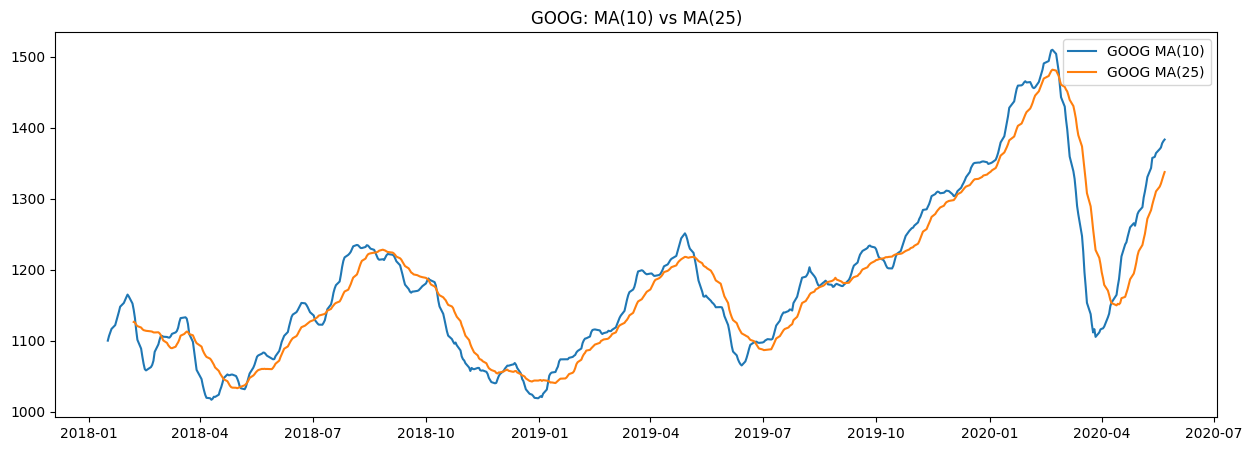

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(target_goog.index, target_goog.rolling(window=10).mean(), label='GOOG MA(10)')
plt.plot(target_goog.index, target_goog.rolling(window=25).mean(), label='GOOG MA(25)')
# Si quieres también puedes mostrar el precio:
# plt.plot(target_goog.index, target_goog, label='GOOG Price', alpha=0.5)
plt.legend(loc='best')
plt.title('GOOG: MA(10) vs MA(25)')
plt.show()

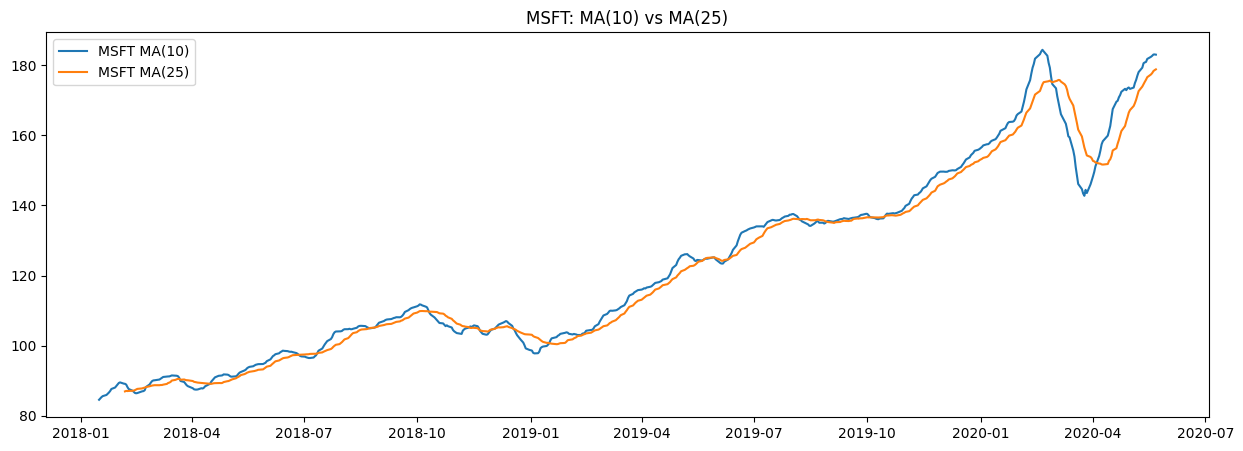

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(target_msft.index, target_msft.rolling(window=10).mean(), label='MSFT MA(10)')
plt.plot(target_msft.index, target_msft.rolling(window=25).mean(), label='MSFT MA(25)')
# Si quieres también puedes mostrar el precio:
# plt.plot(target_msft.index, target_msft, label='MSFT Price', alpha=0.5)
plt.legend(loc='best')
plt.title('MSFT: MA(10) vs MA(25)')
plt.show()

In [34]:
analyzer = TradingStrategyAnalyzer()

# Puedes cambiar ev_goog por el indicador que quieras (por ejemplo, BULL_goog, BBr_goog, etc.)
target = target_goog
ev_goog = BEAR_goog

manperf_goog = analyzer.rolling_test_MA_strategy(target, ev_goog, s=10, m=25, longshort=-1, w_size=252//2)
print("Average Performance (GOOG):")
print(manperf_goog)

Average Performance (GOOG):
{'AvgPerf':      AvgPerf
BH  0.000570
Me  0.001008, 'NumWindows': 475}


In [35]:
analyzer = TradingStrategyAnalyzer()

target = target_msft
ev_msft = BEAR_msft

manperf_msft = analyzer.rolling_test_MA_strategy(target, ev_msft, s=10, m=25, longshort=-1, w_size=252//2)
print("Average Performance (MSFT):")
print(manperf_msft)

Average Performance (MSFT):
{'AvgPerf':      AvgPerf
BH  0.001332
Me  0.000337, 'NumWindows': 467}


## Mean Reversion Strategy

Performance Mean Reversion (GOOG):
Cumulative Return            0.198545
Annual Return                0.078897
Annualized Sharpe Ratio    116.927162
Win %                        0.492611
Annualized Volatility        0.170037
Maximum Drawdown            -0.473935
Max Length Drawdown          0.000000
n.trades                     1.000000
dtype: float64


/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])


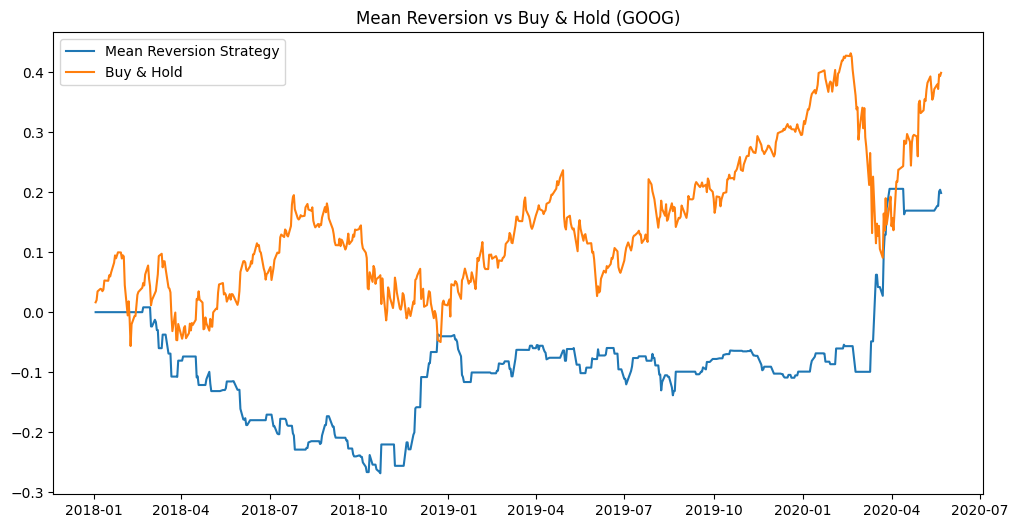

In [37]:
# Calcula la media móvil y los umbrales
window = 20  # puedes ajustar el tamaño de la ventana
mean_PNlog = PNlog_goog.rolling(window).mean()
std_PNlog = PNlog_goog.rolling(window).std()

# Define los umbrales (por ejemplo, 1 desviación estándar)
lower_threshold = mean_PNlog - std_PNlog
upper_threshold = mean_PNlog + std_PNlog

# Señal de mean reversion:
# Compra (1) si PNlog < lower_threshold, vende (-1) si PNlog > upper_threshold, si no, 0
signal = pd.Series(0, index=PNlog_goog.index)
signal[PNlog_goog < lower_threshold] = 1
signal[PNlog_goog > upper_threshold] = -1

# Calcula los retornos diarios
returns = (target_goog / target_goog.shift(1) - 1).dropna()

# Aplica la señal (shift para evitar lookahead bias)
strategy_returns = returns * signal.shift(1)
strategy_returns = strategy_returns.dropna()

# Analiza el performance
analyzer = TradingStrategyAnalyzer()
perf_meanrev = analyzer.performance(strategy_returns)
print("Performance Mean Reversion (GOOG):")
print(perf_meanrev)

# Si quieres ver el equity curve:
plt.figure(figsize=(12,6))
plt.plot(strategy_returns.cumsum(), label='Mean Reversion Strategy')
plt.plot(returns.cumsum(), label='Buy & Hold')
plt.legend()
plt.title('Mean Reversion vs Buy & Hold (GOOG)')
plt.show()

Performance Mean Reversion (MSFT):
Cumulative Return           0.107915
Annual Return               0.044512
Annualized Sharpe Ratio    74.701201
Win %                       0.553571
Annualized Volatility       0.150158
Maximum Drawdown           -0.256306
Max Length Drawdown         0.000000
n.trades                    1.000000
dtype: float64


/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_66269/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])


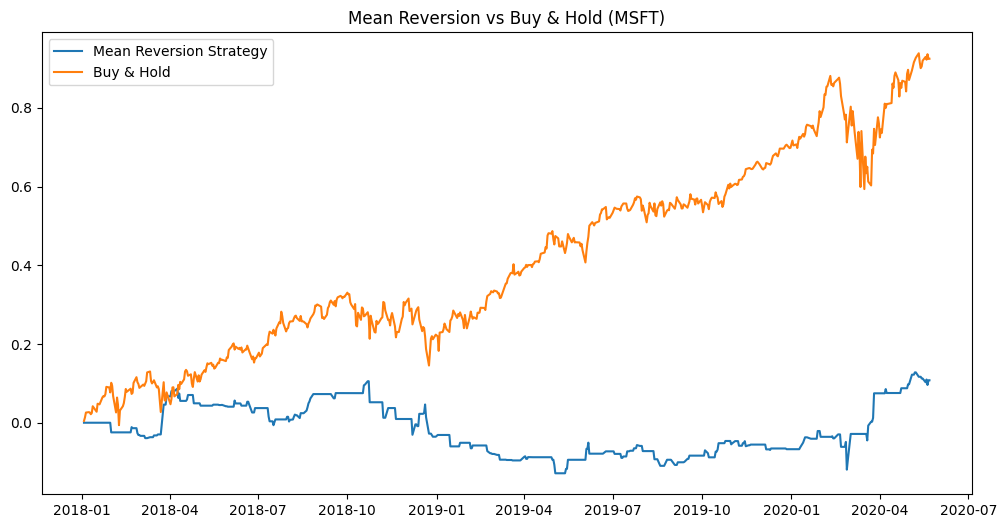

In [39]:
mean_PNlog_msft = PNlog_msft.rolling(window).mean()
std_PNlog_msft = PNlog_msft.rolling(window).std()

lower_threshold_msft = mean_PNlog_msft - std_PNlog_msft
upper_threshold_msft = mean_PNlog_msft + std_PNlog_msft

signal_msft = pd.Series(0, index=PNlog_msft.index)
signal_msft[PNlog_msft < lower_threshold_msft] = 1
signal_msft[PNlog_msft > upper_threshold_msft] = -1

returns_msft = (target_msft / target_msft.shift(1) - 1).dropna()
strategy_returns_msft = returns_msft * signal_msft.shift(1)
strategy_returns_msft = strategy_returns_msft.dropna()

perf_meanrev_msft = analyzer.performance(strategy_returns_msft)
print("Performance Mean Reversion (MSFT):")
print(perf_meanrev_msft)

plt.figure(figsize=(12,6))
plt.plot(strategy_returns_msft.cumsum(), label='Mean Reversion Strategy')
plt.plot(returns_msft.cumsum(), label='Buy & Hold')
plt.legend()
plt.title('Mean Reversion vs Buy & Hold (MSFT)')
plt.show()